In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

from gluonts.torch.model.i_transformer import ITransformerEstimator

In [3]:
dataset = get_dataset("solar_nips", regenerate=False)

In [4]:
train_grouper = MultivariateGrouper(
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality)
)

test_grouper = MultivariateGrouper(
    num_test_dates=int(len(dataset.test) / len(dataset.train)),
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
)

In [5]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [14]:
estimator = ITransformerEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length * 2,
    scaling="std",
    trainer_kwargs=dict(max_epochs=100),
)

In [15]:
predictor = estimator.train(
    dataset_train, cache_data=True, shuffle_buffer_length=1024
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type              | Params
--------------------------------------------
0 | model | ITransformerModel | 33.5 K
--------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 4.92915 (best 4.92915), saving model to '/Users/kashif/Github/gluon-ts/examples/lightning_logs/version_123/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.24070 (best 4.24070), saving model to '/Users/kashif/Github/gluon-ts/examples/lightning_logs/version_123/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.02565 (best 4.02565), saving model to '/Users/kashif/Github/gluon-ts/examples/lightning_logs/version_123/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 3.92258 (best 3.92258), saving model to '/Users/kashif/Github/gluon-ts/examples/lightning_logs/version_123/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 3.82355 (best 3.82355), saving model to '/Users/kashif/Github/gluon-ts/examples/lightning_logs/version_123/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, glo

In [16]:
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)

In [17]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset_test, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 286.99it/s]
Running evaluation: 7it [00:00, 298.34it/s]
Running evaluation: 7it [00:00, 293.57it/s]
Running evaluation: 7it [00:00, 286.25it/s]
Running evaluation: 7it [00:00, 288.41it/s]
Running evaluation: 7it [00:00, 291.39it/s]
Running evaluation: 7it [00:00, 279.51it/s]
Running evaluation: 7it [00:00, 294.37it/s]
Running evaluation: 7it [00:00, 271.10it/s]
Running evaluation: 7it [00:00, 245.00it/s]
Running evaluation: 7it [00:00, 307.14it/s]
Running evaluation: 7it [00:00, 280.07it/s]
Running evaluation: 7it [00:00, 284.74it/s]
Running evaluation: 7it [00:00, 287.54it/s]
Running evaluation: 7it [00:00, 304.67it/s]
Running evaluation: 7it [00:00, 300.12it/s]
Running evaluation: 7it [00:00, 299.93it/s]
Running evaluation: 7it [00:00, 305.45it/s]
Running evaluation: 7it [00:00, 292.77it/s]
Running evaluation: 7it [00:00, 287.94it/s]
Running evaluation: 7it [00:00, 288.46it/s]
Running evaluation: 7it [00:00, 291.44it/s]
Running evaluation: 7it [00:00, 

In [18]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

CRPS: 0.4084152826651918
ND: 0.5465614299699966
NRMSE: 1.061729314965285
MSE: 1069.3143738901447


In [19]:
print("CRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("ND-Sum: {}".format(agg_metric["m_sum_ND"]))
print("NRMSE-Sum: {}".format(agg_metric["m_sum_NRMSE"]))
print("MSE-Sum: {}".format(agg_metric["m_sum_MSE"]))

CRPS-Sum: 0.44710196810926933
ND-Sum: 0.4705363132233221
NRMSE-Sum: 0.8502437566925622
MSE-Sum: 12870809.023809524


In [20]:
def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [
            forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted
        ]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(
            color=color, ls="-", label=f"{label_prefix}median", ax=ax
        )

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)

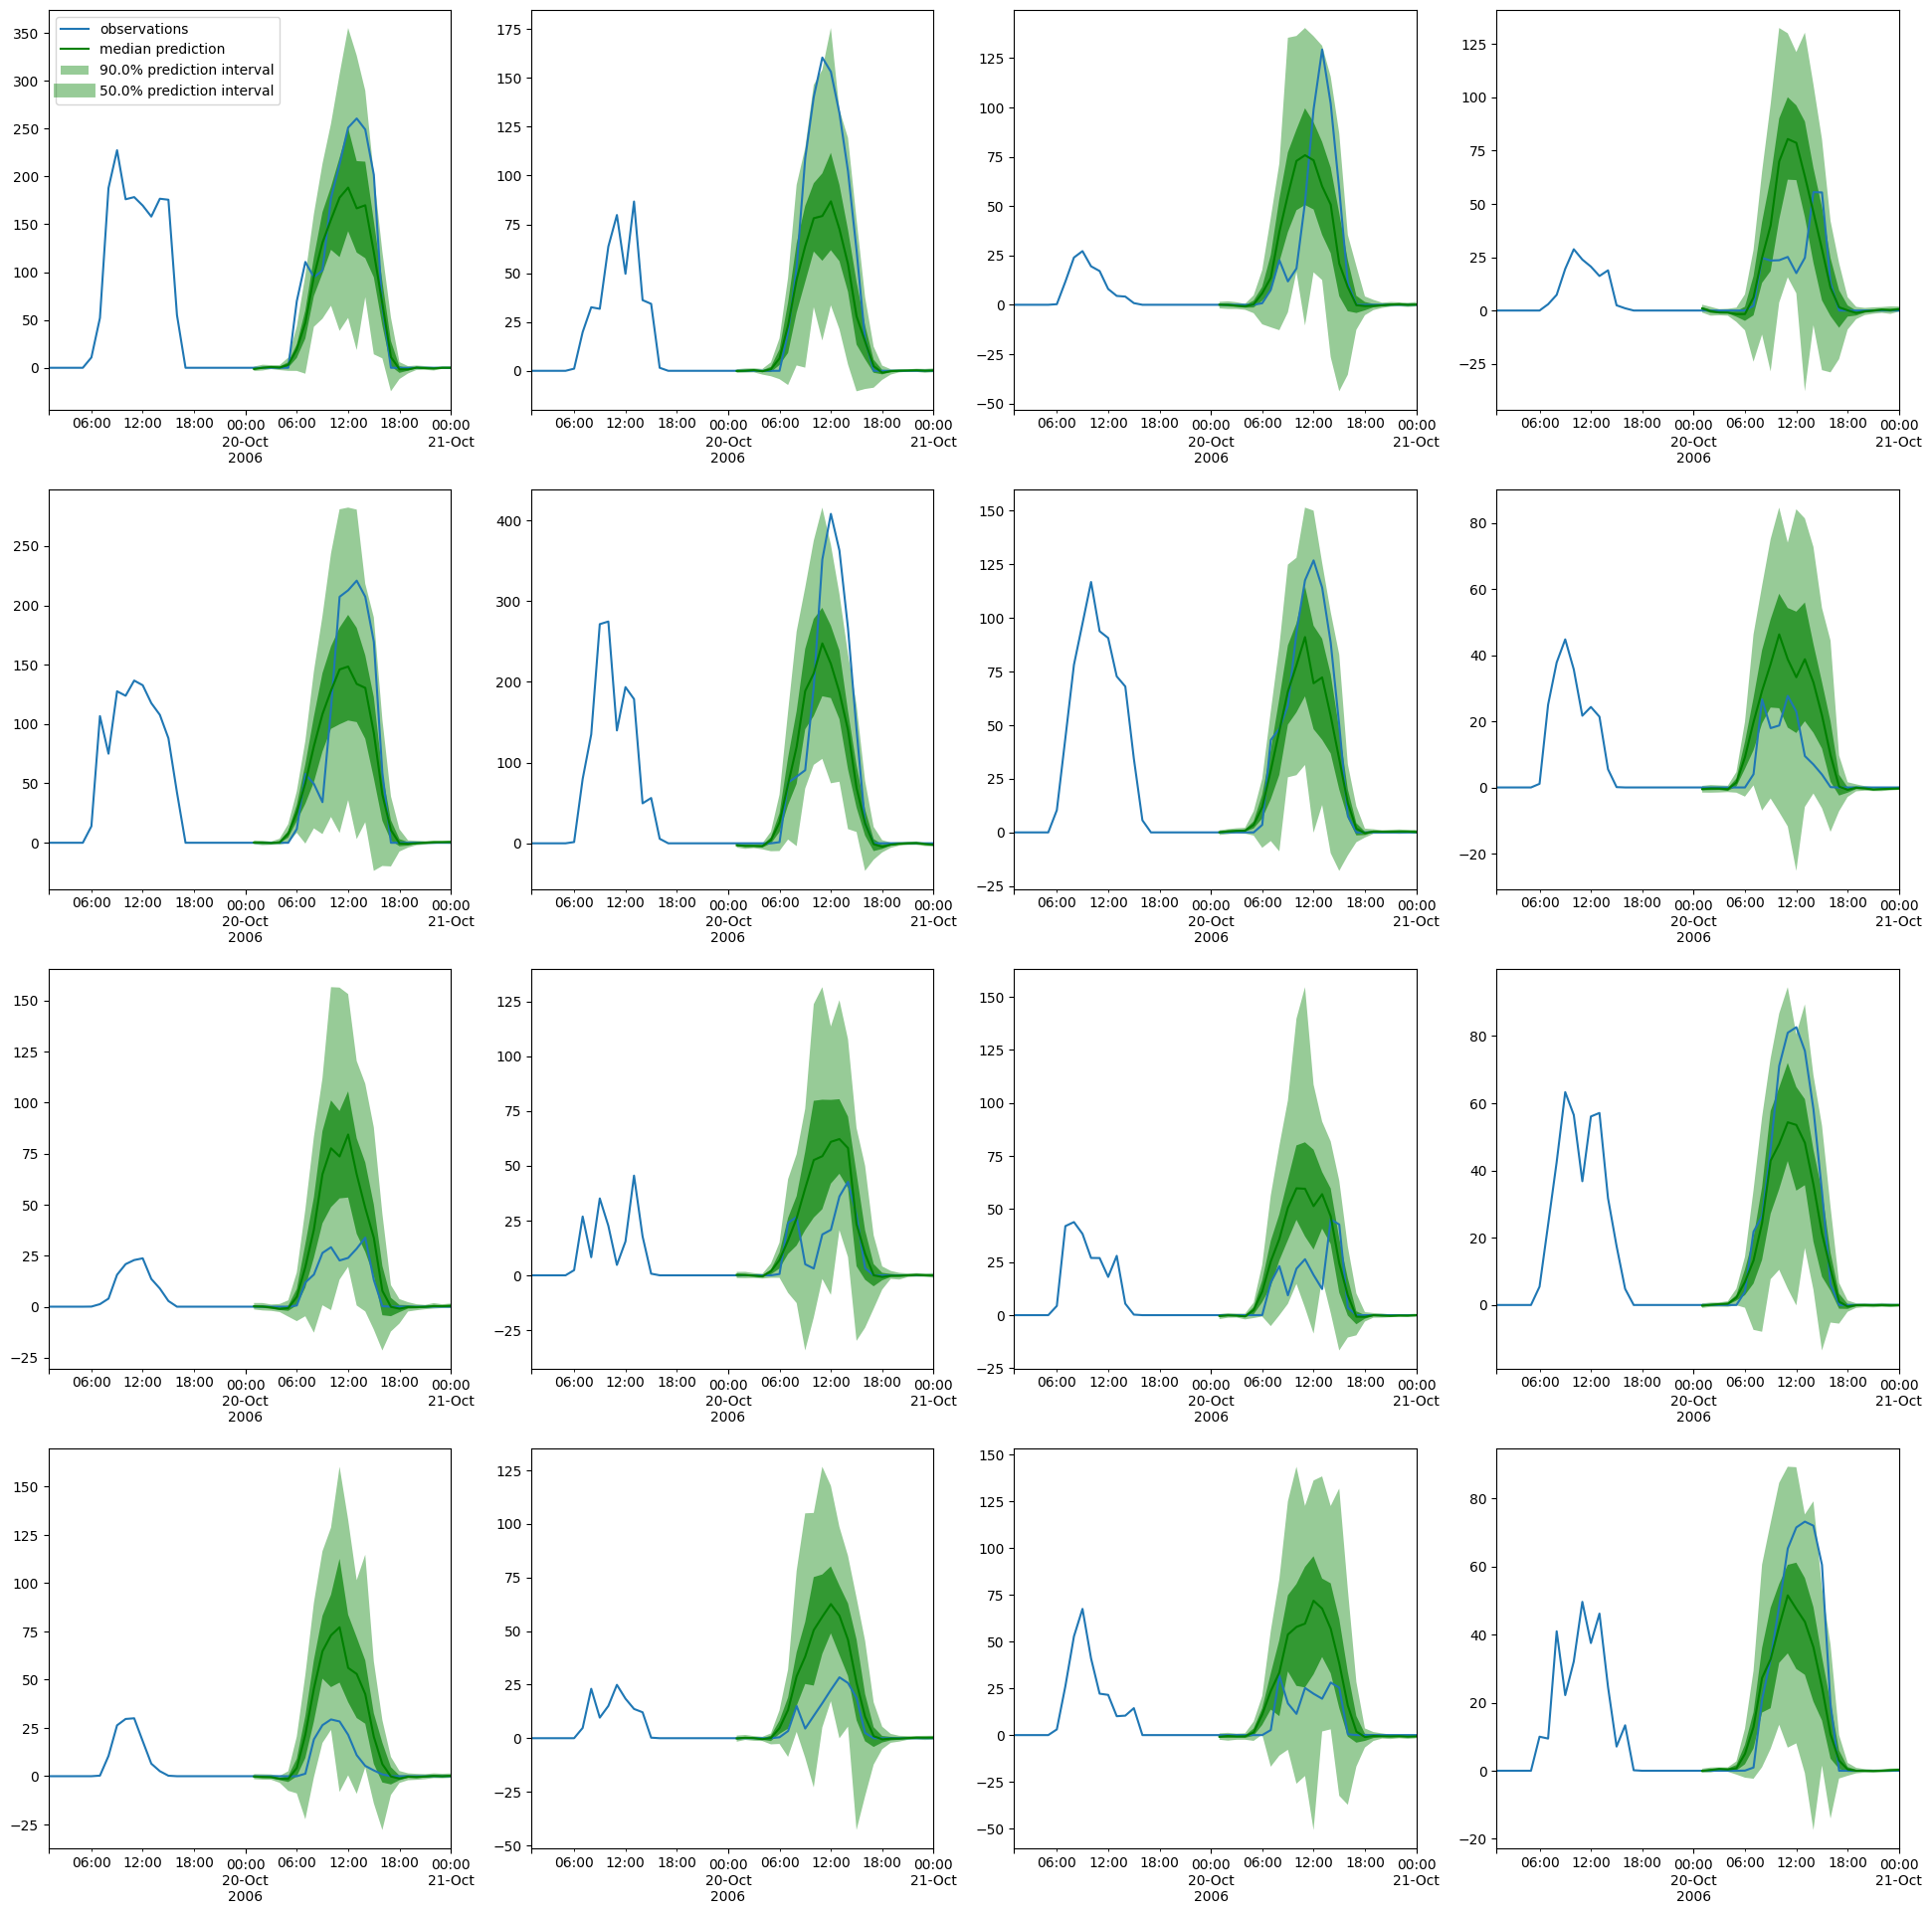

In [21]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()